# Удаление шума с помощью профиля

Это простейший старый приём удаления шума, более сложные развития этого подхода можно найти в различных продуктах для работы с аудио, например в Izotope RX. Несмотря на кажущуюся простоту, во многих случаях даже самая простая версия помогает уничтожить постоянный фоновый шум от улицы или статики.

Ниже приводится описание метода, который вам нужно имплементировать в виде маленькой библиотеки denoiser.py и проиллюстрировать его работу в python-ноутбуке. Сопровождающие комментарии и рисунки удобно вставлять туда же.

1.Опишите кратко структуру: все классы, атрибуты, методы, для этого лучше использовать UML [UML](https://www.visual-paradigm.com/guide/uml-unified-modeling-language/uml-class-diagram-tutorial/). Получится немного, но это важно.

2.Реализуйте класс Denoiser в соответствии с заданием ниже и вспомогательные классы (если вам они нужны). Опишите словами, почему вы спроектировали именно так и в чём удобство вашего решения с точки зрения использования библиотеки.v

3.Проиллюстрируйте работу денойзера в python-ноутбуке, показав, как импортировать библиотеку, создавать объект денойзера, считывать аудио, денойзить и сохранять аудио. Нарисуйте спектрограммы оригинального аудио и обработанного аудио, исходный сигнал(waveform) оригинального и обработанного аудио, дайте комментарии.


# Где найти помощь

Простое и понятное описание для проектирования: [UML](https://www.visual-paradigm.com/guide/uml-unified-modeling-language/uml-class-diagram-tutorial/).

Для понимания того, как устроены спектрограммы и как с ними работать в torch, можете использовать [туториал из нашего курса по звуку](https://github.com/XuMuK1/dla2023/blob/2023/week02/seminar.ipynb), если интересно глубже, советую [лекцию](https://github.com/XuMuK1/dla2023/tree/2023/week02).

Считывание и запись аудиофайлов лучше производить с помощью модуля soundfile (soundfile.read и soundfile.write).

Для нормализации по громкости (если нужно), рекомендую [pyloudnorm](https://github.com/csteinmetz1/pyloudnorm).

# Описание подхода
Назовём объект, используемый для удаления шума, Денойзером (Denoiser). Он должен наследоваться от torch.nn.Module, при инициализации сохранять некоторые гиперпараметры (определите, какие).

## Обучение

Денойзеру вначале подаётся на вход аудио noiseSample с шумом, но без целевого источника звука, например, запись студии звукозаписи без гитары. Денойзер затем из STFT (Short-Time Fourier Transform) спектрограммы, которая считается как модуль(амплитуда) STFT, оценивает спектральный профиль шума, понимая в каких частях спектра находится шум. Профиль сохраняется как одномерный массив, где позиция обозначает номер частоты из FFT, а значение -- амплитуду FFT на этой частоте.
Предложите метод оценки профиля, основываясь на своих знаниях и идеях.

## Денойзинг

При данном входном аудио audioWav денойзер делает STFT-преобразование $F$, получает спектрограмму S шейпа  \[1, freq, time \] и, имея профиль шума P шейпа \[freq\], с учётом правильного broadcasting'a преобразует STFT сигнала к

$$F'(f, t) =  F(f, t) \times (1 - \frac{P(f) * thr}{S(f, t)}) \times \frac{1}{redRate}$$

где thr -- пороговый уровень (threshold) и redRate -- степень гашения шума (reduction Rate), это гиперпараметры метода, позволяющие задавать разные режимы работы денойзера.
Далее делается обратное преобразование iSTFT обработанных значений F', которое выдаётся в качестве итога.
При отладке начните с thr=1 И redRate=1.1, смотрите на спектрограммы и отслушивайте итоговое аудио, это важно.


# Технические требования

Библиотека должна имплементировать объект Denoiser (возможно, с дополнительными классами, если нужно), наследуемый от torch.nn.Module, у которого должны быть реализованы методы

fit -- оценивает профиль шума по данному на входе аудио чисто с шумом;
forward -- использует оценённый профиль, чтобы убрать шум из данного на вход аудио.
Не разрешается использовать nn.Sequential и методы работы со спектрограммами из numpy или scipy (разберитесь с тем, что даёт torch).

Используйте broadcasting вместо циклов где только возможно, этот денойзинг способен работать в режиме реального времени.

[Denoising]('https://www.youtube.com/watch?v=s2K1JfNR7Sc')

In [14]:
!pip install torchaudio

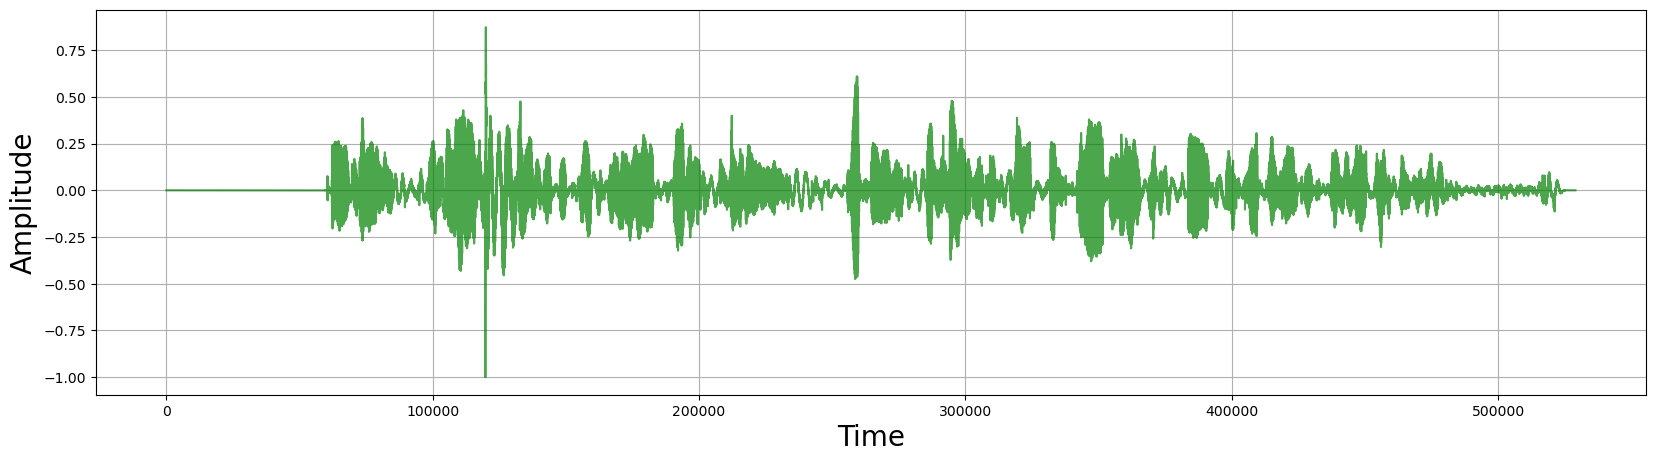

In [12]:
from matplotlib import pyplot as plt
from IPython import display

import torch
import torchaudio
from scipy.io import wavfile

import numpy as np

# Загружаем аудиофайл
wav, sr = torchaudio.load('audio.wav')

def visualize_audio(wav: torch.Tensor, sr: int = sr):
    # Если у аудио больше одного канала (например, стерео), усредняем их для получения моно
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

visualize_audio(wav)

In [13]:
from denoiser import Denoiser
noise, sr_noise = torchaudio.load('noise.wav')
audio, sr_audio = torchaudio.load('audio.wav')

# Если частоты дискретизации отличаются, их следует привести к одному значению
if sr_noise != sr_audio:
    resampler = Resample(orig_freq=sr_noise, new_freq=sr_audio)
    noise = resampler(noise)

# Подгоняем, чтобы оба тензора были одноканальными
if noise.shape[0] > 1:
    noise = torch.mean(noise, dim=0, keepdim=True)
if audio.shape[0] > 1:
    audio = torch.mean(audio, dim=0, keepdim=True)

# Создание экземпляра класса Denoiser
denoiser = Denoiser()

# Подгонка денойзера под профиль шума
denoiser.fit(noise)
# Применение денойзера к аудиосигналу
denoised_audio = denoiser.forward(audio)
# Сохранение очищенного файла
torchaudio.save("denoised_audio.wav", denoised_audio, sr_audio) 

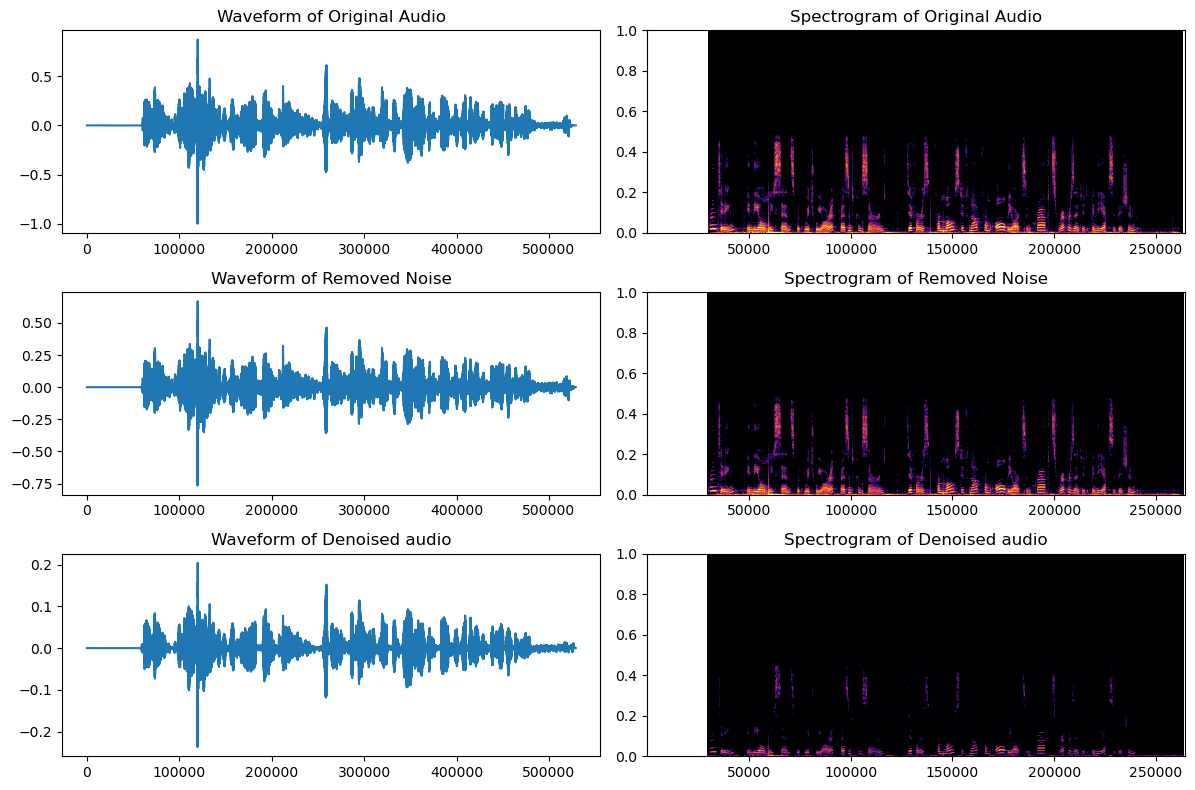

In [14]:
# Визуализация
denoiser.visualize(audio.squeeze(), denoised_audio.squeeze())

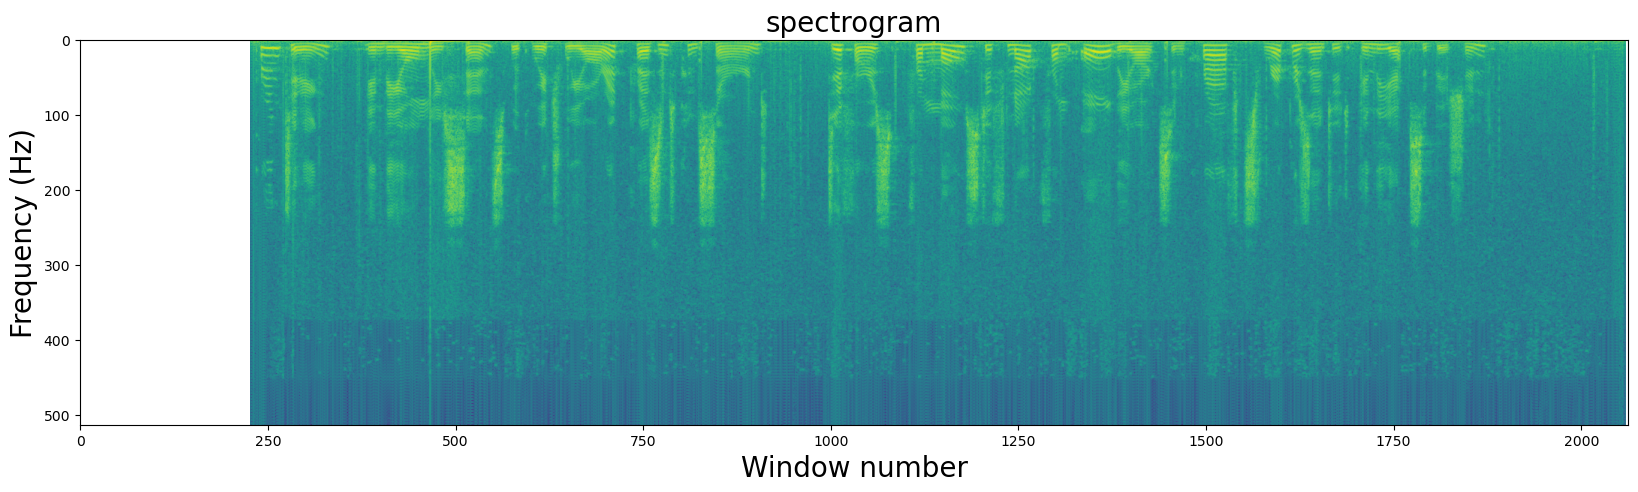

In [15]:
denoiser.plot_windows(denoised_audio)
# там первые несколько секунд нет звука в аудио, поэтому есть белая часть в начале

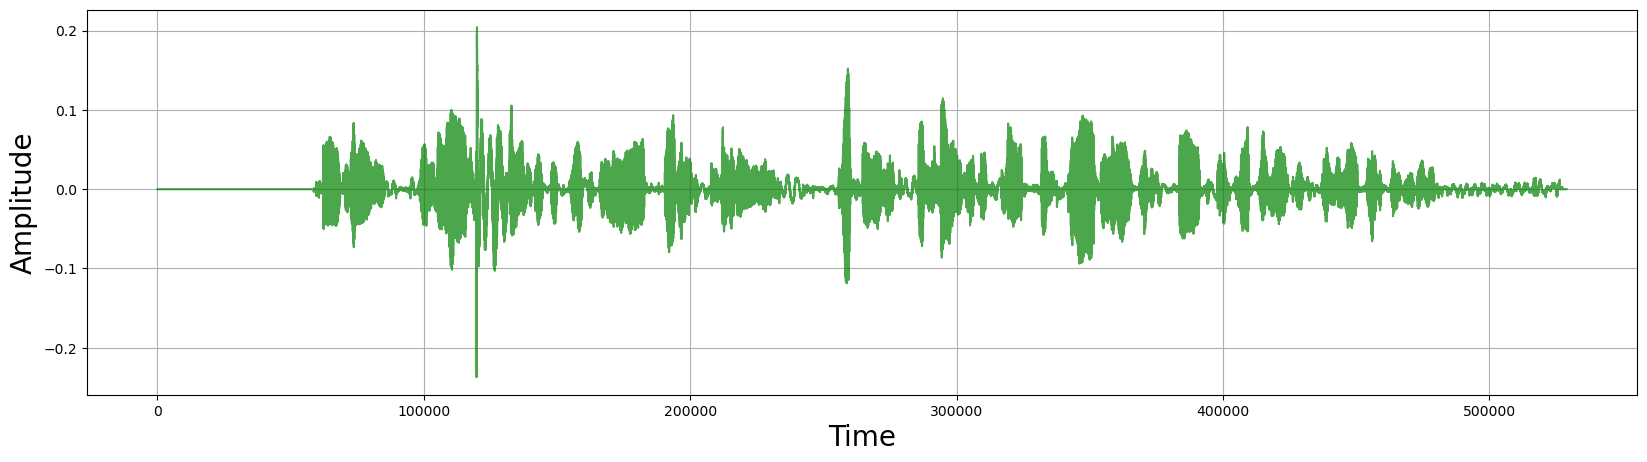

In [11]:
# прослушаем очищенное аудио
wav_denoised, sr_denoised = torchaudio.load('denoised_audio.wav')
visualize_audio(wav_denoised)

Теперь в нашем аудио присутствует гораздо меньший шум, но до сих пор есть небольшой шум. Я игралась с разными параметрами и пока это лучший результат, который мне удалось достигнуть. [Вот здесь](https://www.youtube.com/watch?v=s2K1JfNR7Sc) за 10 минут показывают, как избавится от искуственного шума с искуствеенвыми данными и там прям хорошо убирается шум. Но я взяла реальное аудио из интернета и пыталась работать с реальным шумом из-за чего полностью его убрать у меня не получилось. Надо подбирать параметры и тогда шума будет еще меньше! Но в целом очень даже неплохо убирается шум.

In [6]:
# функция нормализации по частотам, пока не пригодилась, но использовалась для дебага
import torch
from pyloudnorm import Meter
import numpy

def normalize_audio_torch(audio, sample_rate, target_lufs=-23.0):
    """
    Нормализация аудио до заданного LUFS.
    :param audio: Тензор PyTorch или numpy.ndarray содержащий аудиосигнал.
    :param sample_rate: Частота дискретизации.
    :param target_lufs: Желаемый уровень громкости в LUFS.
    :return: Нормализованный аудиосигнал в виде тензора PyTorch.
    """
    meter = Meter(sample_rate)  # создаем объект для измерения громкости
    
    if isinstance(audio, torch.Tensor):
        loudness = meter.integrated_loudness(audio.numpy())
    else:
        loudness = meter.integrated_loudness(audio)
        
    gain = target_lufs - loudness
    normalized_audio = audio * torch.tensor(10 ** (gain / 20.0), dtype=torch.float32)
    
    return normalized_audio
